In [7]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# 파라미터 수에 따른 메모리 크기 계산 (float32 타입 기준, 1 파라미터 = 4 바이트)
def params_to_memory(params):
    memory_bytes = params * 4
    memory_kb = memory_bytes / 1024
    memory_mb = memory_kb / 1024
    return memory_bytes, memory_kb, memory_mb

def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)

  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)


NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


In [11]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Teacher.summary()

# 총 파라미터 수 계산
teacher_total_params = Teacher.count_params()

# Trainable params 계산
teacher_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Teacher.trainable_weights])

# Non-trainable params 계산
teacher_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Teacher.non_trainable_weights])

teacher_total_memory_bytes, teacher_total_memory_kb, teacher_total_memory_mb = params_to_memory(teacher_total_params)
teacher_trainable_memory_bytes, teacher_trainable_memory_kb, teacher_trainable_memory_mb = params_to_memory(teacher_trainable_params)
teacher_non_trainable_memory_bytes, teacher_non_trainable_memory_kb, teacher_non_trainable_memory_mb = params_to_memory(teacher_non_trainable_params)

# 결과 출력
print(f"Total parameters: {teacher_total_params} ({teacher_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {teacher_trainable_params} ({teacher_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {teacher_non_trainable_params} ({teacher_non_trainable_memory_mb:.2f} MB)")



myCP = ModelCheckpoint(save_best_only=True, filepath='teacher.h5', monitor='val_accuracy')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split=0.2,
         callbacks=[myCP])

Total parameters: 1060074 (4.04 MB)
Trainable parameters: 1060074 (4.04 MB)
Non-trainable parameters: 0.0 (0.00 MB)
Epoch 1/20
313/313 [==============================] - 22s 68ms/step - loss: 1.8575 - accuracy: 0.3231 - val_loss: 1.3618 - val_accuracy: 0.5192
Epoch 2/20
313/313 [==============================] - 23s 74ms/step - loss: 1.3554 - accuracy: 0.5140 - val_loss: 1.1927 - val_accuracy: 0.5786
Epoch 3/20
313/313 [==============================] - 25s 79ms/step - loss: 1.2189 - accuracy: 0.5601 - val_loss: 1.0728 - val_accuracy: 0.6316
Epoch 4/20
313/313 [==============================] - 27s 86ms/step - loss: 1.1194 - accuracy: 0.6045 - val_loss: 1.0339 - val_accuracy: 0.6367
Epoch 5/20
313/313 [==============================] - 30s 94ms/step - loss: 1.0453 - accuracy: 0.6314 - val_loss: 0.9962 - val_accuracy: 0.6556
Epoch 6/20
313/313 [==============================] - 33s 107ms/step - loss: 0.9973 - accuracy: 0.6522 - val_loss: 0.9463 - val_accuracy: 0.6692
Epoch 7/20
313/313 

In [12]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# # Evaluation with test set
# Teacher.evaluate(x_test,y_test)
teacher_loss, teacher_accuracy = Teacher.evaluate(x_test, y_test)
print(f"Teacher Model - Loss: {teacher_loss}, Accuracy: {teacher_accuracy}")

313/313 [==============================] - 1s 2ms/step - loss: 0.8642 - accuracy: 0.7130
Teacher Model - Loss: 0.8641906380653381, Accuracy: 0.7129999995231628


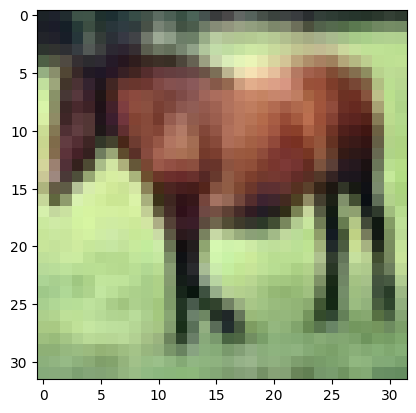

In [13]:
# 기존 Teacher 모델의 로그이트 출력을 얻기 위한 모델 생성
Teacher_logits = Model(Teacher.input, Teacher.layers[-2].output)

# 시각화를 위한 배열 초기화
logits_plot = []

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# 시각화할 아이템 선택
item_idx = 7
item_image = x_train[item_idx]

plt.imshow(item_image)
plt.show()

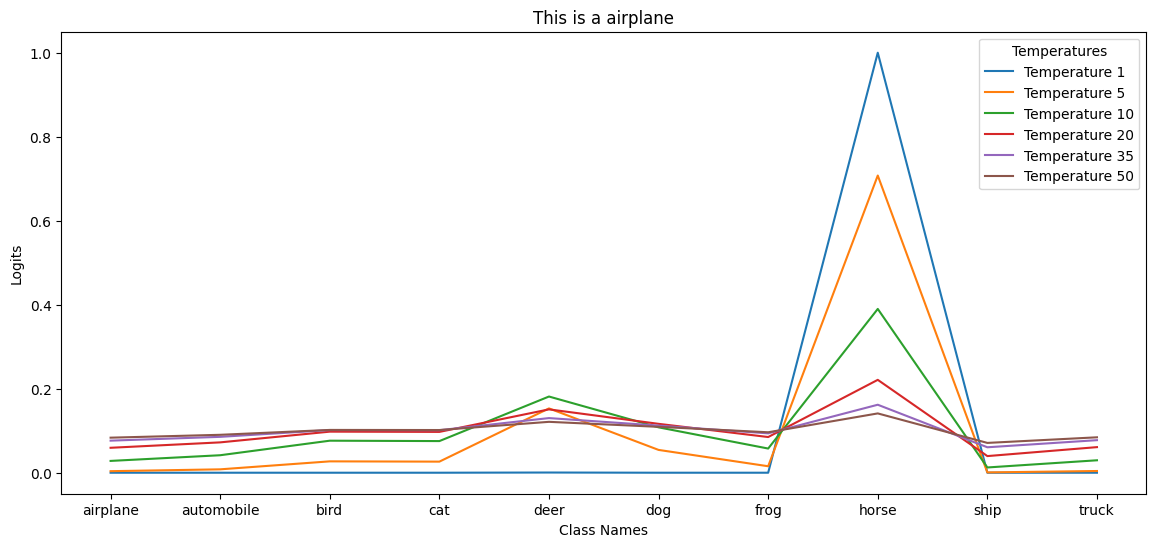

In [14]:
# 다양한 온도 설정
Temperatures = [1, 5, 10, 20, 35, 50]

for Temperature in Temperatures:
    # 온도 레이어 생성
    T_layer = Lambda(lambda x: x / Temperature)(Teacher_logits.output)

    # 소프트맥스 레이어 생성
    Softmax_layer = Softmax()(T_layer)

    # 온도를 적용한 전체 모델 생성
    Teacher_logits_soften = Model(Teacher.input, Softmax_layer)

    # 예측 결과 추가
    logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))

# 플롯 설정
plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
    sns.lineplot(x=class_names, y=logits_plot[i][0], label=f'Temperature {Temperatures[i]}')

plt.title(f'This is a {class_names[np.argmax(y_train[item_idx])]}')
plt.xlabel('Class Names')
plt.ylabel('Logits')
plt.legend(title="Temperatures")
plt.show()

In [15]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
# Student.summary()

# 총 파라미터 수 계산
students_total_params = Student.count_params()

# Trainable params 계산
students_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Student.trainable_weights])

# Non-trainable params 계산
students_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Student.non_trainable_weights])

students_total_memory_bytes, students_total_memory_kb, students_total_memory_mb = params_to_memory(students_total_params)
students_trainable_memory_bytes, students_trainable_memory_kb, students_trainable_memory_mb = params_to_memory(students_trainable_params)
students_non_trainable_memory_bytes, students_non_trainable_memory_kb, students_non_trainable_memory_mb = params_to_memory(students_non_trainable_params)

# 결과 출력
print(f"Total parameters: {students_total_params} ({students_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {students_trainable_params} ({students_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {students_non_trainable_params} ({students_non_trainable_memory_mb:.2f} MB)")


Total parameters: 197322 (0.75 MB)
Trainable parameters: 197322 (0.75 MB)
Non-trainable parameters: 0.0 (0.00 MB)


In [16]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

In [17]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
333/333 [==============================] - 2s 3ms/step - loss: 4.3767 - accuracy: 0.2421 - val_loss: 3.5467 - val_accuracy: 0.3324
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 3.6012 - accuracy: 0.3512 - val_loss: 3.3058 - val_accuracy: 0.3647
Epoch 3/50
333/333 [==============================] - 1s 3ms/step - loss: 3.4088 - accuracy: 0.3716 - val_loss: 3.3553 - val_accuracy: 0.3471
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 3.3585 - accuracy: 0.3770 - val_loss: 3.1197 - val_accuracy: 0.3863
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 3.2500 - accuracy: 0.3861 - val_loss: 3.1771 - val_accuracy: 0.3683
E

In [18]:
StudentModel.load_weights('student.h5')
# StudentModel.evaluate(x_train,y_train_new)

student_loss, student_accuracy = StudentModel.evaluate(x_train,y_train_new)
print(f"Student Model (with KD) - Loss: {student_loss}, Accuracy: {student_accuracy}")


1563/1563 [==============================] - 2s 967us/step - loss: 2.6643 - accuracy: 0.4516
Student Model (with KD) - Loss: 2.6643459796905518, Accuracy: 0.45155999064445496


In [19]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
# AloneModel.summary()

# 총 파라미터 수 계산
alone_total_params = AloneModel.count_params()

# Trainable params 계산
alone_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in AloneModel.trainable_weights])

# Non-trainable params 계산
alone_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in AloneModel.non_trainable_weights])

alone_total_memory_bytes, alone_total_memory_kb, alone_total_memory_mb = params_to_memory(alone_total_params)
alone_trainable_memory_bytes, alone_trainable_memory_kb, alone_trainable_memory_mb = params_to_memory(alone_trainable_params)
alone_non_trainable_memory_bytes, alone_non_trainable_memory_kb, alone_non_trainable_memory_mb = params_to_memory(alone_non_trainable_params)

# 결과 출력
print(f"Total parameters: {alone_total_params} ({alone_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {alone_trainable_params} ({alone_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {alone_non_trainable_params} ({alone_non_trainable_memory_mb:.2f} MB)")

AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#val_acc -> val_accuracy
myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_accuracy')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])


Total parameters: 197322 (0.75 MB)
Trainable parameters: 197322 (0.75 MB)
Non-trainable parameters: 0.0 (0.00 MB)
Epoch 1/50
333/333 [==============================] - 2s 4ms/step - loss: 2.1868 - accuracy: 0.2154 - val_loss: 1.9675 - val_accuracy: 0.2872
Epoch 2/50
333/333 [==============================] - 1s 2ms/step - loss: 1.8700 - accuracy: 0.3317 - val_loss: 1.9363 - val_accuracy: 0.3041
Epoch 3/50
333/333 [==============================] - 1s 2ms/step - loss: 1.8131 - accuracy: 0.3571 - val_loss: 1.7900 - val_accuracy: 0.3687
Epoch 4/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7563 - accuracy: 0.3788 - val_loss: 1.7970 - val_accuracy: 0.3603
Epoch 5/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7468 - accuracy: 0.3841 - val_loss: 1.8160 - val_accuracy: 0.3447
Epoch 6/50
333/333 [==============================] - 1s 2ms/step - loss: 1.7410 - accuracy: 0.3841 - val_loss: 1.7339 - val_accuracy: 0.3889
Epoch 7/50
333/333 [==============

In [20]:
AloneModel = load_model("alone.h5")
# AloneModel.evaluate(x_test,y_test)
alone_loss, alone_accuracy = AloneModel.evaluate(x_test, y_test)
print(f"Alone Model (without KD) - Loss: {alone_loss}, Accuracy: {alone_accuracy}")

313/313 [==============================] - 0s 800us/step - loss: 1.6981 - accuracy: 0.3910
Alone Model (without KD) - Loss: 1.6980971097946167, Accuracy: 0.39100000262260437


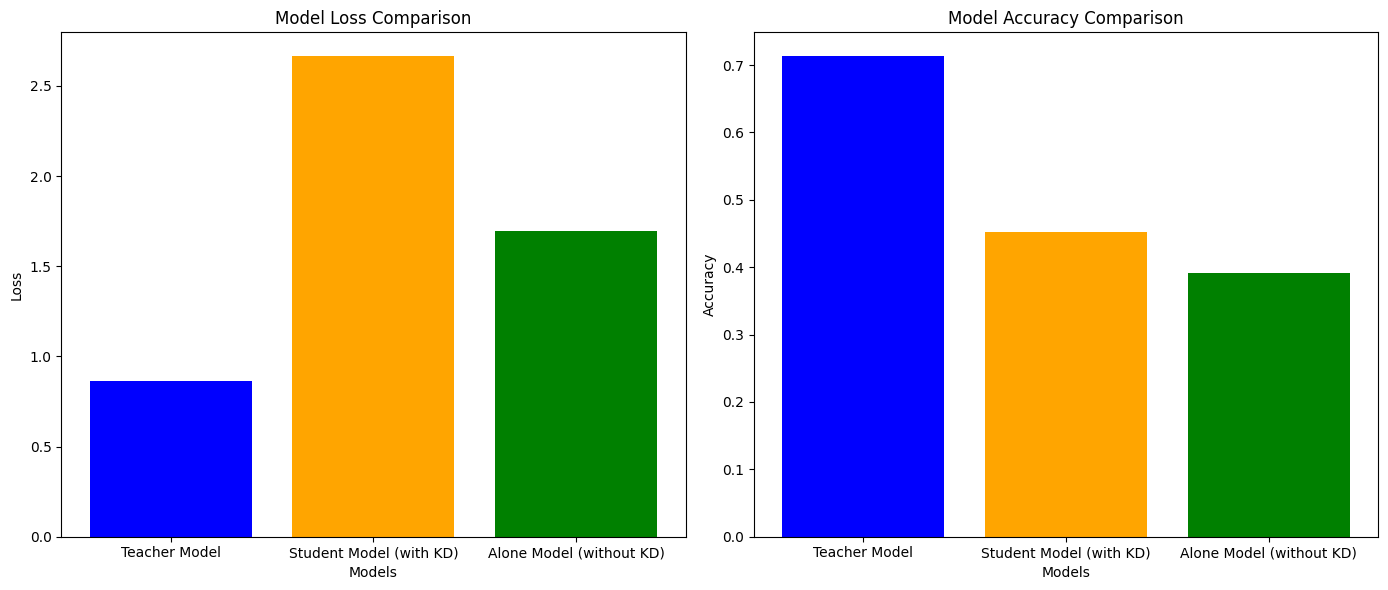

In [21]:
# Data for plotting
models = ['Teacher Model', 'Student Model (with KD)', 'Alone Model (without KD)']
losses = [teacher_loss, student_loss, alone_loss]
accuracies = [teacher_accuracy, student_accuracy, alone_accuracy]

# Plotting the losses
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(models, losses, color=['blue', 'orange', 'green'])
plt.title('Model Loss Comparison')
plt.xlabel('Models')
plt.ylabel('Loss')

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [22]:
def measure_inference_time(model, x_test, n_runs=100):
    start_time = time.time()
    for _ in range(n_runs):
        _ = model.predict(x_test)
    end_time = time.time()
    avg_time_per_run = (end_time - start_time) / n_runs
    return avg_time_per_run

# Measure inference time for Teacher and Student models
teacher_inference_time = measure_inference_time(Teacher, x_test)
student_inference_time = measure_inference_time(StudentModel, x_test)

print(f"Teacher Model - Average Inference Time: {teacher_inference_time:.6f} seconds")
print(f"Student Model - Average Inference Time: {student_inference_time:.6f} seconds")

Teacher Model - Average Inference Time: 1.173597 seconds
Student Model - Average Inference Time: 0.682717 seconds
